In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Mon Oct 13 09:58:13 PDT 2025
lutzes
/mnt/share/homes/lutzes/vivarium_research_alzheimers/verification_and_validation


## V&V List from Docs 

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

# Load Data

In [2]:
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [3]:
locations = [
            'united_states_of_america',
             'brazil',
             'china',
             'germany',
             'israel',
             'japan',
             'spain',
             'sweden',
             'taiwan_(province_of_china)',
             'united_kingdom',
            ]



results_dirs = [
    'results/model5.0/model_spec/2025_09_25_09_02_38/results/',
]

artifact_dirs = ['artifacts/model5.0/' + x + '.hdf' for x in locations]
artifact_dirs

['artifacts/model5.0/united_states_of_america.hdf',
 'artifacts/model5.0/brazil.hdf',
 'artifacts/model5.0/china.hdf',
 'artifacts/model5.0/germany.hdf',
 'artifacts/model5.0/israel.hdf',
 'artifacts/model5.0/japan.hdf',
 'artifacts/model5.0/spain.hdf',
 'artifacts/model5.0/sweden.hdf',
 'artifacts/model5.0/taiwan_(province_of_china).hdf',
 'artifacts/model5.0/united_kingdom.hdf']

In [4]:
[x for x in os.listdir(results_dirs[0]) if 'parquet' in x]

['deaths.parquet',
 'ylls.parquet',
 'new_simulants.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'ylds.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet']

In [4]:
age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
art = Artifact(artifact_dirs[0],
               filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
              )

age_dictionary = pd.DataFrame()
age_dictionary['age_group_id'] = age_group_ids
age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
artifact = art.load('population.structure').reset_index()
artifact = artifact.loc[artifact.age_start > 29].reset_index()
age_dictionary['age_start'] = artifact.age_start
age_dictionary['age_end'] = artifact.age_end

# tweak final row to be named age group 95_plus
assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
age_dictionary.loc[13, 'age_group'] = '95_plus'

age_dictionary.tail()

,age_group_id,age_group_name,age_group,age_start,age_end
9,20,75 to 79,75_to_79,75.0,80.0
10,30,80 to 84,80_to_84,80.0,85.0
11,31,85 to 89,85_to_89,85.0,90.0
12,32,90 to 94,90_to_94,90.0,95.0
13,33,95 to 99,95_plus,95.0,125.0


In [12]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.lower()
    
    df_prev_pop = pd.merge(
        art.load('population.scaling_factor').query("year_start == 2023"),
        art.load('population.structure').query("year_start==2025").droplevel(['year_start', 'year_end']),
        left_index=True,
        right_index=True,
        suffixes=['_prev', '_pop']
    )
    prev = ((df_prev_pop.filter(like='draw_').filter(like='_prev')
            * df_prev_pop.filter(like='draw_').filter(like='_pop').values).mean(axis=1)).sum(axis=0)
    # TODO: use draw-specific scale instead of mean
    
    ratio = 100_000 / prev
    print(ratio)

    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'current_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    ## I'd like to add a line that duplicates the data for the year 2050 for all years up to 2100
    mini = temp.loc[temp['current_year'] == 2050]
    for year in range(2051, 2100):
        temp = pd.concat([temp, mini.assign(current_year=year)], ignore_index=True)
    scale = pd.concat([scale, temp], ignore_index=True)
#scale

0.018283685923580616
0.04583767883804687
0.005042604291586587
0.039606953062466733
1.758450962578899
0.02577213823808569
0.13774040936958382
0.5625178546183628
0.3650829538988746
0.08726914922159383


## Verifying Prevalence

In [6]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers.prevalence'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']
art_prev_data.head()

draw_0  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_1  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_2  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_3  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_4  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_5  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_6  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_7  \
sex    age_sta

In [9]:
def load_df(measure):
    data = pd.DataFrame()
    for i, location in enumerate(locations):
        print(location, i)
        data_all = pd.read_parquet(results_dirs[0] + measure + '.parquet', filters=[('artifact_path', '==', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/' + artifact_dirs[i])])

        # aggregate by summing value column over random seeds
        cols = [c for c in data_all.columns if c not in ['value', 'random_seed']]
        data_all = data_all.groupby(cols)['value'].sum().reset_index()
    
        data_all['location'] = location
        # temp['location'] = locations[results_dirs.index(results_dirs)].title()
        data_all['current_year'] = data_all['current_year'].astype(int)
        data = pd.concat([data, data_all], ignore_index=True)
    return data

In [46]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims = new_sims.loc[new_sims.sub_entity == 'alzheimers_disease_state']
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_sims['total_prev'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

new_sims = new_sims.merge(age_dictionary, on=['age_group'])
new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.tail()

united_states_of_america 0
brazil 1
china 2
germany 3
israel 4
japan 5
spain 6
sweden 7
taiwan_(province_of_china) 8
united_kingdom 9


,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
7275,2050,taiwan_(province_of_china),95_plus,Male,25.0,5030.976546,1827.058082,2231.463824,2303.924642,5828.429804,7439.585112,7740.132823,33,95 to 99,95.0,125.0
7276,2050,united_kingdom,95_plus,Female,25.0,34912.261604,10895.347626,15501.148871,17109.823654,36134.900368,50331.656267,50941.368123,33,95 to 99,95.0,125.0
7277,2050,united_kingdom,95_plus,Male,25.0,11941.855444,3939.453784,5695.236918,5998.370496,12728.165573,17349.804403,17487.592393,33,95 to 99,95.0,125.0
7278,2050,united_states_of_america,95_plus,Female,25.0,173296.173779,58838.674910,76755.626622,84121.536096,180804.578526,258820.740251,266219.533249,33,95 to 99,95.0,125.0
7279,2050,united_states_of_america,95_plus,Male,25.0,68689.298078,24799.125441,35980.056321,36292.449803,65794.451810,113344.028145,120627.728807,33,95 to 99,95.0,125.0


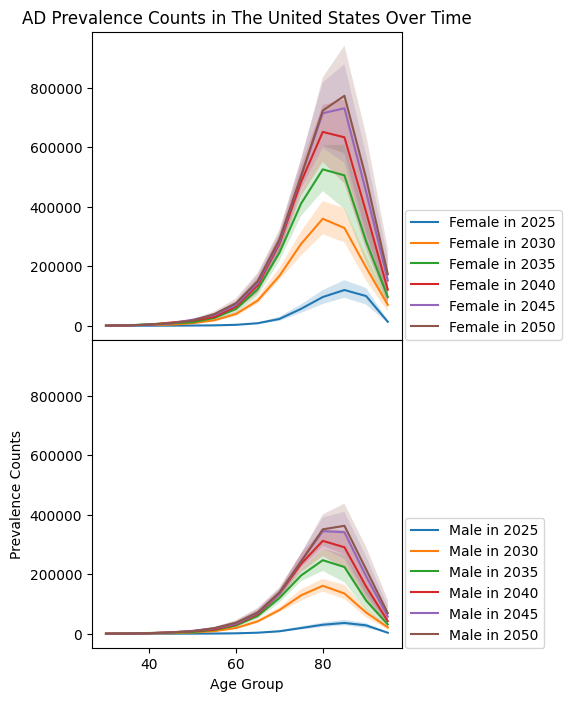

In [77]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(4,8))
plt.subplots_adjust(hspace=0)
for i, sex in enumerate(['Female','Male']):
    for year in [2025,2030,2035,2040,2045,2050]:
        plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.current_year == year) & (new_sims.sex == sex)]

        ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'{sex} in {year}')
        ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

        # ax[i].set_title(f"Total Alzheimer's Prevalence Counts in the US Over Time")
        # ax[i].set_tick_params(axis='x', labelrotation=90)
# plt.xlabel("Age Group")
# plt.ylabel(f"Prevalence Counts")
# plt.legend()
        if i == 0:
            ax[i].set_title(f"AD Prevalence Counts in The United States Over Time")
#             plt.tick_params(axis='x', labelrotation=90)
        ax[i].set_xlabel("Age Group")
        if i == 1:
            ax[i].set_ylabel(f"Prevalence Counts")
        ax[i].legend(loc=(1.01, 0))

        #plt.figure()

In [13]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims = new_sims.loc[new_sims.sub_entity == 'alzheimers_disease_state']
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_sims['total_prev'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(['input_draw','current_year','location','sex']).sum(numeric_only=True)
new_sims = new_sims.groupby(['current_year','location','sex']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()
new_sims['location'] = new_sims['location'].str.replace('_', ' ').str.title()

# new_sims = new_sims.merge(age_dictionary, on=['age_group'])
# new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.tail()

united_states_of_america 0
brazil 1
china 2
germany 3
israel 4
japan 5
spain 6
sweden 7
taiwan_(province_of_china) 8
united_kingdom 9


,current_year,location,sex,count,mean,std,min,2.5%,50%,97.5%,max
1495,2099,Taiwan (Province Of China),Male,25.0,8.124647e+04,10971.423490,6.092335e+04,6.113744e+04,8.353442e+04,9.629274e+04,9.643190e+04
1496,2099,United Kingdom,Female,25.0,7.065352e+05,81489.682409,5.592183e+05,5.649296e+05,7.083394e+05,8.214334e+05,8.345474e+05
1497,2099,United Kingdom,Male,25.0,2.947168e+05,33358.457160,2.380402e+05,2.408580e+05,2.944070e+05,3.405924e+05,3.441887e+05
1498,2099,United States Of America,Female,25.0,3.350201e+06,414358.393884,2.658770e+06,2.665100e+06,3.373329e+06,3.935950e+06,3.959560e+06
1499,2099,United States Of America,Male,25.0,1.576512e+06,190093.982473,1.256534e+06,1.256863e+06,1.577231e+06,1.860128e+06,1.892666e+06


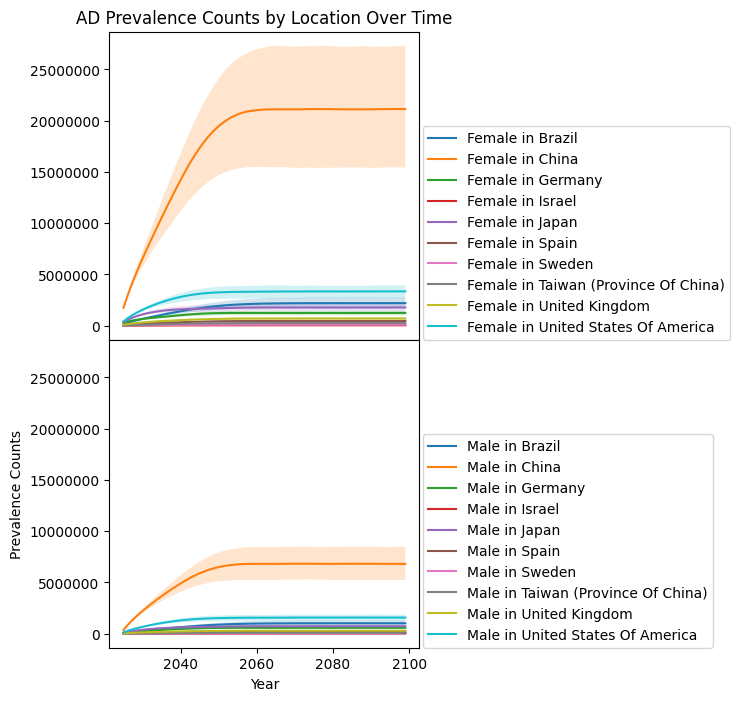

In [14]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(4,8))
plt.subplots_adjust(hspace=0)
for i, sex in enumerate(['Female','Male']):
    for location in new_sims.location.unique():
        plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.sex == sex)]

        ax[i].plot(plot_data.current_year, plot_data['mean'], label=f'{sex} in {location}')
        ax[i].fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

        # ax[i].set_title(f"Total Alzheimer's Prevalence Counts in the US Over Time")
        # ax[i].set_tick_params(axis='x', labelrotation=90)
# plt.xlabel("Age Group")
# plt.ylabel(f"Prevalence Counts")
# plt.legend()
        if i == 0:
            ax[i].set_title(f"AD Prevalence Counts by Location Over Time")
#             plt.tick_params(axis='x', labelrotation=90)
        ax[i].set_xlabel("Year")
        if i == 1:
            ax[i].set_ylabel(f"Prevalence Counts")
        ax[i].legend(loc=(1.01, 0))
        ax[i].ticklabel_format(style='plain')

        #plt.figure()

In [15]:
def load_df_single_loc(measure):
    data = pd.DataFrame()
    for i, location in enumerate(locations[:1]):
        print(location, i)
        data_all = pd.read_parquet(results_dirs[0] + measure + '.parquet', filters=[('artifact_path', '==', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/' + artifact_dirs[i])])

        # aggregate by summing value column over random seeds
        cols = [c for c in data_all.columns if c not in ['value', 'random_seed']]
        data_all = data_all.groupby(cols)['value'].sum().reset_index()
    
        data_all['location'] = location
        # temp['location'] = locations[results_dirs.index(results_dirs)].title()
        data_all['current_year'] = data_all['current_year'].astype(int)
        data = pd.concat([data, data_all], ignore_index=True)
    return data

In [16]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df_single_loc('person_time_alzheimers_disease_and_other_dementias')
# new_sims = new_sims.loc[new_sims.sub_entity == 'alzheimers_disease_state']
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_sims['total_prev'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(['input_draw','current_year','location','sex','sub_entity']).sum(numeric_only=True)
new_sims = new_sims.groupby(['current_year','location','sex','sub_entity']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()
new_sims['location'] = new_sims['location'].str.replace('_', ' ').str.title()
#rename all the values in the sub_entity column to be more readable
new_sims['sub_entity'] = new_sims['sub_entity'].str.replace('alzheimers_disease_state', 'AD Dementia')
new_sims['sub_entity'] = new_sims['sub_entity'].str.replace('alzheimers_mild_cognitive_impairment_state', 'Mild Cognitive Impairment')
new_sims['sub_entity'] = new_sims['sub_entity'].str.replace('alzheimers_blood_based_biomarker_state', 'Preclinical')

# new_sims = new_sims.merge(age_dictionary, on=['age_group'])
# new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.tail()

united_states_of_america 0


,current_year,location,sex,sub_entity,count,mean,std,min,2.5%,50%,97.5%,max
445,2099,United States Of America,Female,AD Dementia,25.0,3.350201e+06,414358.393884,2.658770e+06,2.665100e+06,3.373329e+06,3.935950e+06,3.959560e+06
446,2099,United States Of America,Female,Mild Cognitive Impairment,25.0,1.397400e+06,64351.895977,1.263714e+06,1.282770e+06,1.409004e+06,1.484883e+06,1.488665e+06
447,2099,United States Of America,Male,Preclinical,25.0,1.408060e+06,66988.399766,1.283197e+06,1.297748e+06,1.417855e+06,1.496398e+06,1.509354e+06
448,2099,United States Of America,Male,AD Dementia,25.0,1.576512e+06,190093.982473,1.256534e+06,1.256863e+06,1.577231e+06,1.860128e+06,1.892666e+06
449,2099,United States Of America,Male,Mild Cognitive Impairment,25.0,7.422184e+05,33577.253725,6.732628e+05,6.827332e+05,7.507857e+05,7.850887e+05,7.895608e+05


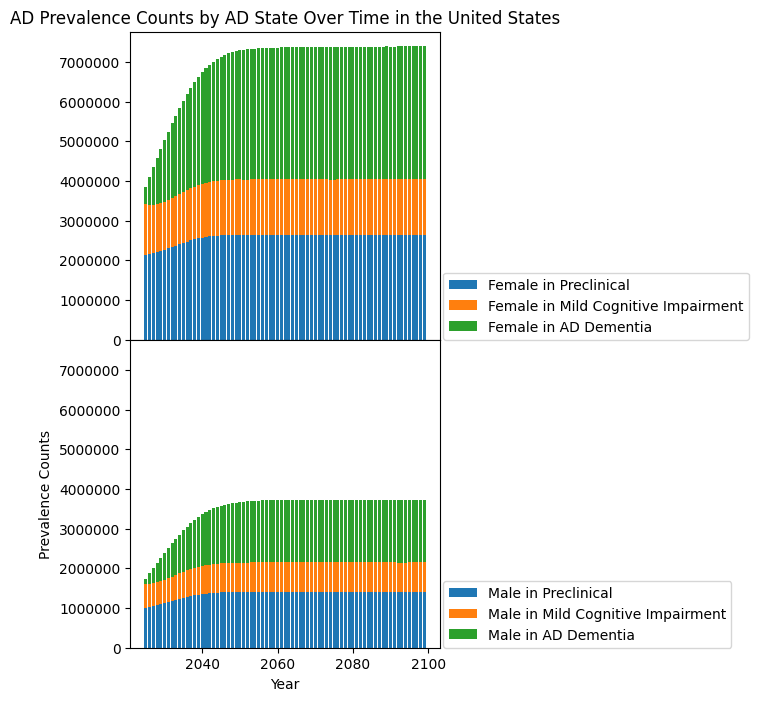

In [17]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(4,8))
plt.subplots_adjust(hspace=0)
for i, sex in enumerate(['Female','Male']):
    # for sub_entity in new_sims.sub_entity.unique():

# Instead of a line plot, I want a stacked bar chart with the sub_entity as the different colors in a stacked bar chart
    plot_data1 = new_sims.loc[(new_sims.sub_entity == 'Preclinical') & (new_sims.sex == sex)].reset_index()
    ax[i].bar(plot_data1.current_year, plot_data1['mean'], label=f'{sex} in Preclinical')

    plot_data2 = new_sims.loc[(new_sims.sub_entity == 'Mild Cognitive Impairment') & (new_sims.sex == sex)].reset_index()
    ax[i].bar(plot_data2.current_year, plot_data2['mean'], label=f'{sex} in Mild Cognitive Impairment', bottom=plot_data1['mean'])
    
    plot_data3 = new_sims.loc[(new_sims.sub_entity == 'AD Dementia') & (new_sims.sex == sex)].reset_index()
    ax[i].bar(plot_data3.current_year, plot_data3['mean'], label=f'{sex} in AD Dementia', bottom = plot_data1['mean'] + plot_data2['mean'])

    #ax[i].fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

    # ax[i].set_title(f"Total Alzheimer's Prevalence Counts in the US Over Time")
    # ax[i].set_tick_params(axis='x', labelrotation=90)
# plt.xlabel("Age Group")
# plt.ylabel(f"Prevalence Counts")
# plt.legend()
    if i == 0:
        ax[i].set_title(f"AD Prevalence Counts by AD State Over Time in the United States")
#             plt.tick_params(axis='x', labelrotation=90)
    ax[i].set_xlabel("Year")
    if i == 1:
        ax[i].set_ylabel(f"Prevalence Counts")
    ax[i].legend(loc=(1.01, 0))
    ax[i].ticklabel_format(style='plain')

    #plt.figure()

## Deaths

In [79]:
deaths = load_df('deaths')
deaths

,measure,entity_type,entity,sub_entity,age_group,current_year,sex,artifact_path,input_draw_number,scenario,input_draw,value,location
0,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2025,Female,/mnt/team/simulation_science/pub/models/vivari...,2,baseline,2,0.0,united_states_of_america
1,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2025,Female,/mnt/team/simulation_science/pub/models/vivari...,2,baseline,13,0.0,united_states_of_america
2,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2025,Female,/mnt/team/simulation_science/pub/models/vivari...,2,baseline,24,0.0,united_states_of_america
3,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2025,Female,/mnt/team/simulation_science/pub/models/vivari...,2,baseline,41,0.0,united_states_of_america
4,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2025,Female,/mnt/team/simulation_science/pub/models/vivari...,2,baseline,46,0.0,united_states_of_america
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5699995,deaths,cause,other_causes,other_causes,95_plus,2100,Male,/mnt/team/simulation_science/pub/models/vivari...,499,baseline,446,0.0,united_states_of_america
5699996,deaths,cause,other_causes,other_causes,95_plus,2100,Male,/mnt/team/simulation_science/pub/models/vivari...,499,baseline,457,0.0,united_states_of_america
5699997,deaths,cause,other_causes,other_causes,95_plus,2100,Male,/mnt/team/simulation_science/pub/models/vivari...,499,baseline,460,0.0,united_states_of_america
5699998,deaths,cause,other_causes,other_causes,95_plus,2100,Male,/mnt/team/simulation_science/pub/models/vivari...,499,baseline,480,0.0,united_states_of_america


In [80]:
cols = ['input_draw','current_year','location','age_group','sex']

deaths = load_df('deaths')
deaths = deaths.loc[deaths.sub_entity == 'alzheimers_disease_state']
deaths = deaths.merge(scale[['location','sex','age_group','ratio','current_year']])
deaths['total_deaths'] = deaths['value'] / deaths['ratio']
deaths = deaths.groupby(cols).sum(numeric_only=True)
deaths = deaths.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_deaths'].reset_index()

deaths = deaths.merge(age_dictionary, on=['age_group'])
deaths = deaths.loc[deaths['age_group_id'].isin(age_group_ids)]
deaths.tail()

,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
723,2048,united_states_of_america,95_plus,Male,25.0,7525.834811,1899.502672,3281.614016,4594.259623,7274.244403,11463.771631,12579.520397,33,95 to 99,95.0,125.0
724,2049,united_states_of_america,95_plus,Female,25.0,20440.079837,5188.555706,9899.535616,10949.652102,20127.232634,30365.868366,30464.316786,33,95 to 99,95.0,125.0
725,2049,united_states_of_america,95_plus,Male,25.0,7608.969033,1931.150257,3062.839749,4539.566056,7383.631537,11102.794089,11102.794089,33,95 to 99,95.0,125.0
726,2050,united_states_of_america,95_plus,Female,25.0,20949.823881,4864.230525,11704.423325,12688.907530,20674.168304,30683.091054,31503.494558,33,95 to 99,95.0,125.0
727,2050,united_states_of_america,95_plus,Male,25.0,7829.931043,1917.311834,3773.856119,4627.075763,8149.341474,11879.442740,12306.052562,33,95 to 99,95.0,125.0


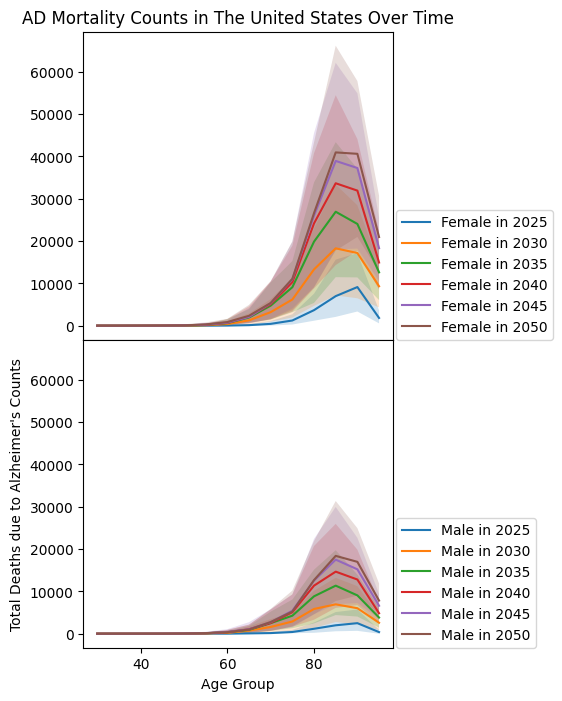

In [82]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(4,8))
plt.subplots_adjust(hspace=0)
for i, sex in enumerate(['Female','Male']):
    for year in [2025,2030,2035,2040,2045,2050]:
        plot_data = deaths.loc[(deaths.location == location) & (deaths.current_year == year) & (deaths.sex == sex)]

        ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'{sex} in {year}')
        ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

        if i == 0:
            ax[i].set_title(f"AD Mortality Counts in The United States Over Time")
#             plt.tick_params(axis='x', labelrotation=90)
        ax[i].set_xlabel("Age Group")
        if i == 1:
            ax[i].set_ylabel(f"Total Deaths due to Alzheimer's Counts")
        ax[i].legend(loc=(1.01, 0))

        #plt.figure()